<a href="https://colab.research.google.com/github/KarinkinK/personal_projects/blob/master/titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [ ]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


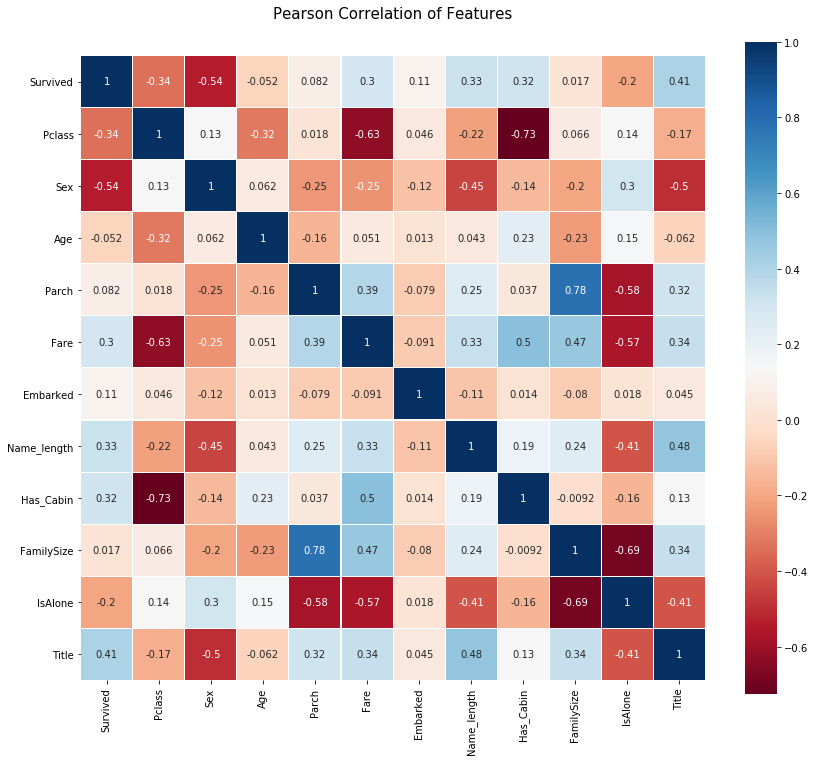

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

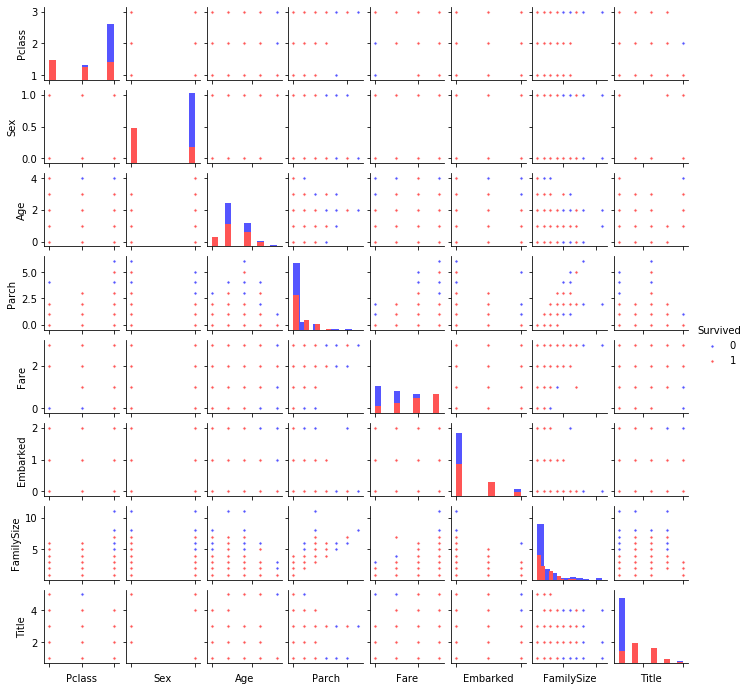

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, diag_kind = 'hist', plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [ ]:
#определение переменных с данными и разделение на тест и валидацию
data = train.drop('Survived', axis = 1)
targets = train['Survived']

train, valid, train_true, valid_true = train_test_split(data, targets, test_size=0.3, random_state=17)

In [ ]:
# создание моделей базовых алгоритмов
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
lr = LogisticRegression(random_state=17)
svc = SVC(random_state=17)

meta = XGBClassifier()

In [ ]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)
from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}  # LogisticRegression

skf = StratifiedKFold(n_splits=5, random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [ ]:
#объекты GridSearchCV для каждого базового алгоритма
clf_gbc = GridSearchCV(gbc, gbc_params, cv=skf)
clf_rfc = GridSearchCV(rfc, rfc_params, cv=skf)
clf_svc = GridSearchCV(svc, svc_params, cv=skf)
clf_lr = GridSearchCV(lr, lr_params, cv=skf)

#обучение базовых алгоритмов
clf_gbc.fit(train, train_true)
clf_rfc.fit(train, train_true)
clf_svc.fit(train, train_true)
clf_lr.fit(train, train_true)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
#наилучшие параметры для каждой модели

print(f'Best Params: \nGradientBoosting {clf_gbc.best_params_} \
      \nRandomForest {clf_rfc.best_params_} \
      \nSVC {clf_svc.best_params_} \
      \nLogisticRegression {clf_lr.best_params_}')

Best Params: 
GradientBoosting {'learning_rate': 0.1}       
RandomForest {'min_samples_leaf': 3, 'n_estimators': 30}       
SVC {'C': 0.1, 'kernel': 'linear'}       
LogisticRegression {'C': 0.7999999999999999}


In [ ]:
#метрики точности для каждого базового алгоритма

from sklearn.metrics import accuracy_score

gbc_pred = clf_gbc.predict(valid)
print(f'Accuracy GradientBoosting {accuracy_score(valid_true, gbc_pred)}')

rfc_pred = clf_rfc.predict(valid)
print(f'Accuracy RandomForest {accuracy_score(valid_true, rfc_pred)}')

svc_pred = clf_svc.predict(valid)
print(f'Accuracy SVC {accuracy_score(valid_true, svc_pred)}')

lr_pred = clf_lr.predict(valid)
print(f'Accuracy LogisticRegression {accuracy_score(valid_true, lr_pred)}')

Accuracy GradientBoosting 0.7611940298507462
Accuracy RandomForest 0.7873134328358209
Accuracy SVC 0.7873134328358209
Accuracy LogisticRegression 0.7910447761194029


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [ ]:
#параметры мета-алгоритма
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

#создание объекта алгоритма
meta_clf = GridSearchCV(meta, xgb_params, cv=5)

models = [clf_gbc, clf_rfc, clf_svc, clf_lr]

#определение матрицы и заполнение предсказаниями базовых алгоритмов
meta_mtrx = np.empty((valid.shape[0], len(models)))
for n, model in enumerate(models):
    model.fit(train, train_true)
    meta_mtrx[:, n] = model.predict(valid)    

In [ ]:
#обучение мета-алгоритма
meta_clf.fit(meta_mtrx, valid_true)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'min_child_weight': range(1, 10),
                         'n_esti

In [ ]:
print(f'Best Params XGBClassifier {meta_clf.best_params_}')

Best Params XGBClassifier {'eta': 0.1, 'min_child_weight': 1, 'n_estimators': 10, 'subsample': 0.7000000000000001}


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [ ]:
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state=17)
rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, random_state=17)
lr = LogisticRegression(C=0.7999999999999999, random_state=17)
svc = SVC(C=0.1, kernel='linear', random_state=17)

meta = XGBClassifier(n_estimators=10, min_child_weight=1, subsample=0.7000000000000001, eta=0.1)

In [ ]:
from sklearn.model_selection import cross_val_predict

#список базовых моделей
models = [gbc, rfc, svc, lr]

#определение матрицы с мета-признаками
meta_mtrx = np.empty((targets.shape[0], len(models)))
 
#заполнение матрицы предсказаниями базовых алгоритмов 
for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, data, targets, cv = 5, method='predict')
    model.fit(data, targets)

#обучение мета алгоритма    
meta.fit(meta_mtrx, targets)

#определение и заполнение матрицы с тестовыми мета-признаками
meta_mtrx_test = np.empty((test.shape[0], len(models)))
for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(test)

#обучение мета-алгоритма на тестовых мета-празнаках
meta_predict = meta.predict(meta_mtrx_test)

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [ ]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerID, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [ ]:
write_to_submission_file(meta_predict, PassengerId)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: 0.80382